<a href="https://colab.research.google.com/github/Flaagrah/MachineLearning/blob/main/NeuralNetworkLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

class ActivationFunction:
    def __init__(self):
        pass

    def calculate_activation(self, x):
        raise NotImplementedError("Subclasses must implement this method.")

    def calculate_gradient(self, x):
        raise NotImplementedError("Subclasses must implement this method.")


class ReLU(ActivationFunction):
    def calculate_activation(self, x):
        def _calculate_activation_helper(val):
          return np.maximum(0,val)
        vectorized_function = np.vectorize(_calculate_activation_helper)
        return vectorized_function(x)

    def _calculate_gradient(self, x):
        def _calculate_gradient_helper(val):
          if val >= 0:
            return 1
          return 0
        vectorized_function = np.vectorize(_calculate_gradient_helper)
        return vectorized_function(x)

class LeakyReLU(ActivationFunction):
    leakFactor = 0.1
    def calculate_activation(self, x):
        def _calculate_activation_helper(val):
          if val < 0:
            return self.leakFactor*val
          return val
        vectorized_function = np.vectorize(_calculate_activation_helper)
        return vectorized_function(x)

    def _calculate_gradient(self, x):
        def _calculate_gradient_helper(val):
          if val >= 0:
            return 1
          return self.leakFactor
        vectorized_function = np.vectorize(_calculate_gradient_helper)
        return vectorized_function(x)

class NoActivation(ActivationFunction):
    def calculate_activation(self, x):
        return x

    def _calculate_gradient(self, x):
        return np.ones(x.shape)

Here we define a simple feedforward network that takes in any number of layers of any size and the activation function that should be used for those layers.

The feed_forward function propagates the input forward to calculate the output.
The calculation at each layer is done by multiplying the activation of the previous layer with the weights between the current and previous layer. The bias is added to this result to form the activation of this layer. These activations are then passed on to the next layer for further computation.

The backpropogate function is used to back-propogate the deltas between the output and the labels. This allows for the calculation of the gradients at each layer to adjust its weights. The derivative of the activation function is used to adjust the magnitude of the gradient for each weight and bias.

In [ ]:
class SimpleFeedForwardNetwork:
  def __init__(self, layerSizes, activationsByLayer):
    self.weights = []
    self.biases = []
    self.num_layers = len(layerSizes)
    for i in range(0, len(layerSizes)-1):
      self.biases.append(np.random.rand(layerSizes[i+1])/np.sqrt(1./layerSizes[i+1]) - 0.5)
      self.weights.append(np.random.rand(layerSizes[i], layerSizes[i+1])/np.sqrt(1./layerSizes[i+1]) - 0.5)
    self.activationsByLayer = activationsByLayer
    self.valuesCache = {}

  def _clip_gradients(self, gradients):
    MAX_ABS = 1
    def max_abs(num):
      if num > MAX_ABS:
        return MAX_ABS
      elif num < -1*MAX_ABS:
        return -1*MAX_ABS
      return num
    vectorized_max = np.vectorize(max_abs)
    return vectorized_max(gradients)

  def _feed_layer(self, i):
    input_label = 'a'+str(i-1)
    z_label = 'z'+str(i)
    a_label = 'a'+str(i)
    activation = self.activationsByLayer[i-1]
    inputs = self.valuesCache[input_label]
    self.valuesCache[z_label] = np.matmul(inputs, self.weights[i-1]) + self.biases[i-1]
    self.valuesCache[a_label] = activation.calculate_activation(self.valuesCache[z_label])

  def feed_forward(self, input):
    self.valuesCache['a0'] = input
    for i in range(1,len(self.weights)+1):
      self._feed_layer(i)
    return self.valuesCache['a'+str(len(self.weights))]

  def back_propagate(self, y, output):
    current_batch_size = y.shape[0]
    num_layers = len(self.weights)

    gradients = {}
    activation = self.activationsByLayer[-1]
    last_layer_num = str(self.num_layers-1)
    d_output = -2 * (y - output)
    for i in range(self.num_layers - 1, 0, -1):
      a_values = self.valuesCache["a"+str(i-1)]
      z_values = self.valuesCache["z"+str(i)]
      activation = self.activationsByLayer[i-1]
      d_output_act_grad = d_output * activation._calculate_gradient(z_values)
      gradients['dw'+str(i)] = (1./current_batch_size) * np.matmul(a_values.transpose(), d_output_act_grad)
      gradients['db'+str(i)] = (1./current_batch_size) * np.sum(d_output_act_grad, axis=0, keepdims=False)
      d_output = np.matmul(self.weights[i-1], d_output.transpose()).transpose()

    return gradients

  def train_step(self, learning_rate, batchX, y):
    output = self.feed_forward(batchX)
    gradients = self.back_propagate(y, output)
    for i in range(0, len(self.weights)):
      self.weights[i] -= learning_rate * self._clip_gradients(gradients['dw'+str(i+1)])
      self.biases[i] -= learning_rate * self._clip_gradients(gradients['db'+str(i+1)])

  def train(self, x, y, learning_rate, batch_size, epochs):
    for i in range(0,epochs):
      currIndex = 0
      while currIndex < x.shape[0]:
        endIndex = currIndex + batch_size
        batchX = x[currIndex:endIndex]
        batchY = y[currIndex:endIndex]
        self.train_step(learning_rate, batchX, batchY)
        currIndex += batch_size

  def predict(self, input):
    return self.feed_forward(input)

# Modelling Linear Regression With A Neural Network:

We can model multiple linear regression with a neural network by creating two layers (an input layer and an output layer with one node). The bias of the output node represents the constant while the weights represent the all of the other coefficients.

The following code generates random population betas and inputs for a linear regression problem.

In [ ]:
NUM_FEATURES = 100
SAMPLE_SIZE = 10000
TRAIN_SIZE = 8000
ERROR_SIZE = 0.01
def generateParameters(numberOfFeatures):
  popBetas = np.random.rand(numberOfFeatures+1, 1) - 0.5
  return popBetas

popBetas = generateParameters(NUM_FEATURES) * 5
sampleX = np.random.rand(SAMPLE_SIZE, NUM_FEATURES) - 0.5

We then calculate the population labels using the sample inputs and a random error term.

In [ ]:
sampleY = np.ones([SAMPLE_SIZE,1]) * popBetas[0]
sampleY = sampleY + np.sum(popBetas[1:len(popBetas)].reshape(1,NUM_FEATURES)*sampleX, axis=1,keepdims=True)
sampleY = sampleY + np.random.rand(SAMPLE_SIZE, 1)*ERROR_SIZE - ERROR_SIZE/2.0


We create the simple neural network with any number of features in the input layer and 1 node in the output layer. There is no activation needed as it is supposed to be a simple linear function of the weights and bias.

In [ ]:
SFFN = SimpleFeedForwardNetwork([NUM_FEATURES,1], [NoActivation()])

In [ ]:
SFFN.train(sampleX[:TRAIN_SIZE], sampleY[:TRAIN_SIZE], 0.001, 10, 100)

In [ ]:
test_output = SFFN.predict(sampleX[TRAIN_SIZE:])
print(test_output)
print(sampleY[TRAIN_SIZE:])


[[-5.22646556]
 [-8.66001577]
 [-2.0594118 ]
 ...
 [ 1.36766714]
 [-7.4308176 ]
 [-2.24361132]]
[[-5.22192362]
 [-8.66068618]
 [-2.06417596]
 ...
 [ 1.36713907]
 [-7.42610197]
 [-2.23831678]]


As you can see in the above results, the test output matches very closely with the predicted output as the neural network is converging towards the betas. The following graph shows a comparison between the weights of the network and the population betas. As you can see, the population betas match so closely with the parameters of the model that the two lines seem to perfectly overlap.

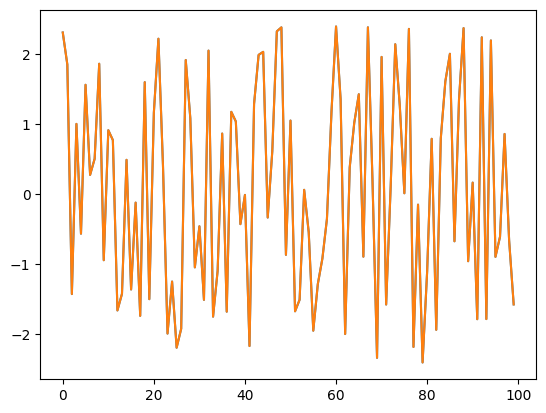

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(SFFN.weights).flatten())
plt.plot(np.array(popBetas[1:]).flatten())

We now test our neural network with a hidden layer. In order to do this, we initialize a target model with random weights and biases to represent a hypothetical domain. We generate random inputs for that domain and use that target model to predict the output. Under the assumption that the target model is modelling this hypothetical domain perfectly, we can use these outputs as labels that we use to train another model. As you can see, the outputs of the trained model are very close to the outputs of the target model, indicating that the trained model is mastering the domain of the target model.

In [ ]:
target_model = SimpleFeedForwardNetwork([NUM_FEATURES, 50, 10], [NoActivation(), ReLU()])
train_model = SimpleFeedForwardNetwork([NUM_FEATURES, 50, 10], [NoActivation(), ReLU()])

sampleX = np.random.rand(SAMPLE_SIZE, NUM_FEATURES)
sampleY = target_model.predict(sampleX[:TRAIN_SIZE])
train_model.train(sampleX[:TRAIN_SIZE], sampleY[:TRAIN_SIZE], 0.001, 10, 100)
print(train_model.predict(sampleX[TRAIN_SIZE:]))
print(target_model.predict(sampleX[TRAIN_SIZE:]))

[[7772.75047155 8157.08260821 8822.15062258 ... 8094.59360708
  6210.44827795 9049.08848057]
 [7717.16385086 8116.49257512 8807.08180318 ... 8007.96626653
  6199.62052167 8978.35563695]
 [7074.72793275 7477.02537032 8099.60459789 ... 7417.02248738
  5716.55492479 8333.62930299]
 ...
 [8388.04275945 8824.63876922 9572.51611045 ... 8770.7711544
  6741.73296045 9788.73838569]
 [7616.00547814 7904.57616971 8593.79843937 ... 7867.92911663
  6079.01925742 8818.7396572 ]
 [7544.56793705 7981.97901621 8617.8891904  ... 7918.43324845
  6044.42428349 8850.43122653]]
[[7784.31118738 8159.85772125 8818.95848729 ... 8095.92871143
  6212.49527134 9054.62702795]
 [7719.52940094 8125.89164577 8810.17689216 ... 8015.21649987
  6209.70239259 8983.04371638]
 [7084.10918229 7481.04759549 8092.82510226 ... 7422.73334963
  5713.64367393 8336.4408741 ]
 ...
 [8403.53937383 8825.32516103 9572.46752979 ... 8772.79449222
  6749.00970054 9793.46572148]
 [7618.94194757 7909.3429999  8597.88068171 ... 7878.1721376